In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltb
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import re

In [95]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.reader import Reader

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [4]:
calendar = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv',error_bad_lines=False)

b'Skipping line 4963: expected 6 fields, saw 8\nSkipping line 58248: expected 6 fields, saw 10\nSkipping line 102313: expected 6 fields, saw 13\nSkipping line 121854: expected 6 fields, saw 8\n'
b'Skipping line 131455: expected 6 fields, saw 10\nSkipping line 136170: expected 6 fields, saw 8\nSkipping line 141017: expected 6 fields, saw 8\nSkipping line 150629: expected 6 fields, saw 8\n'


In [96]:
description_corpus.words_

{'walking distance': 1.0,
 'great location': 0.9949178758194005,
 'highly recommend': 0.8810488325845179,
 'great host': 0.8610886057302791,
 'definitely stay': 0.8048169698755248,
 'place stay': 0.7591515062237608,
 'everything needed': 0.6492597775649996,
 'great place': 0.6209766516903586,
 'clean comfortable': 0.533696692936584,
 'definitely recommend': 0.4926714296236282,
 'Capitol Hill': 0.4805185239743684,
 'stay Seattle': 0.4668925388524711,
 'downtown Seattle': 0.4610002209619209,
 'within walking': 0.45540251896589823,
 'enjoyed stay': 0.4504677027325624,
 'great stay': 0.42063784341165206,
 'gave us': 0.41577668115194816,
 'will definitely': 0.4028872357663696,
 'us feel': 0.3997201149001989,
 'location great': 0.3865360536200928,
 'recommend place': 0.3663548648449584,
 'place great': 0.362377550268837,
 'made us': 0.35957869927082564,
 'come back': 0.343743094939972,
 'really enjoyed': 0.342564631361862,
 'next time': 0.3422700154673345,
 'recommend staying': 0.34153347573

#### Lets analyse the reviews

In [4]:
reviews['comments'] = reviews['comments'].astype('str')

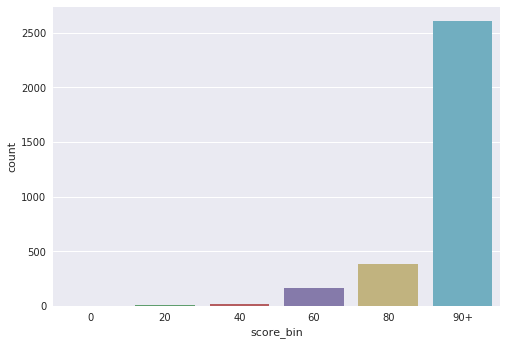

In [49]:
bins = [0, 20, 40, 60,80,90,100]
labels = ["0", "20", "40", "60","80","90+"]
rv_df['score_bin'] = pd.cut(rv_df['review_scores_rating'], bins=bins, labels=labels)

sns.countplot(x="score_bin", data=rv_df)

In [36]:
rv_df2 = rv_df.groupby(['number_of_reviews', 'review_scores_rating'])['id'].agg('sum')
rv_df2 = pd.DataFrame(rv_df2) 

#### handling negative sentiments

In [86]:
def negate(string):
    return re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]', 
       lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
       string,
       flags=re.IGNORECASE)

In [88]:
reviews['comments'] = reviews['comments'].apply(negate)

In [89]:
description_corpus = ' '.join(reviews['comments'])

##### generate word cloud to see frequent words

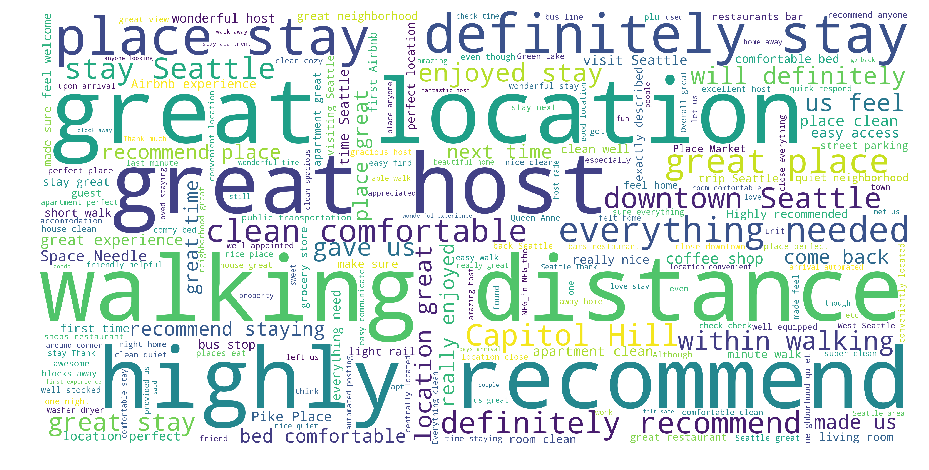

In [90]:
description_corpus = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_corpus)
plt.axis('off')
plt.show()

In [96]:
description_corpus.words_

{'walking distance': 1.0,
 'great location': 0.9949178758194005,
 'highly recommend': 0.8810488325845179,
 'great host': 0.8610886057302791,
 'definitely stay': 0.8048169698755248,
 'place stay': 0.7591515062237608,
 'everything needed': 0.6492597775649996,
 'great place': 0.6209766516903586,
 'clean comfortable': 0.533696692936584,
 'definitely recommend': 0.4926714296236282,
 'Capitol Hill': 0.4805185239743684,
 'stay Seattle': 0.4668925388524711,
 'downtown Seattle': 0.4610002209619209,
 'within walking': 0.45540251896589823,
 'enjoyed stay': 0.4504677027325624,
 'great stay': 0.42063784341165206,
 'gave us': 0.41577668115194816,
 'will definitely': 0.4028872357663696,
 'us feel': 0.3997201149001989,
 'location great': 0.3865360536200928,
 'recommend place': 0.3663548648449584,
 'place great': 0.362377550268837,
 'made us': 0.35957869927082564,
 'come back': 0.343743094939972,
 'really enjoyed': 0.342564631361862,
 'next time': 0.3422700154673345,
 'recommend staying': 0.34153347573

##### This gives us various genres: = ['walking','recommend','location',
#####          'bus stop','easy access',
#####          'great neighborhood','public transportation','centrally located','location convenient','walk']

In [5]:
reviews['walking_distance'] = pd.np.where(reviews.comments.str.contains('|'.join(['walking',
                    'walk'])),1,0)

In [6]:
reviews['is_recommend'] = pd.np.where(reviews.comments.str.contains("recommend"),1,0)
reviews['is_clean'] = pd.np.where(reviews.comments.str.contains("clean"),1,0)
reviews['near_coffee'] = pd.np.where(reviews.comments.str.contains("coffee"),1,0)

In [7]:
reviews['transportation'] = pd.np.where(reviews.comments.str.contains('|'.join(['bus stop',
                    'public transportation'])),1,0)
reviews['convenient_location'] = pd.np.where(reviews.comments.str.contains('|'.join(['centrally located',
                                                                                     'location'])),1,0)

####  Since the review score rating is at a aggregated level for each host,we can directly map to customer level

In [8]:
reviews['total_score'] = reviews[['walking_distance', 'is_recommend', 'transportation',
       'convenient_location', 'is_clean', 'near_coffee']].sum(axis=1) ## create an aggregated score

In [9]:
reviews['total_score'].unique()

array([1, 2, 0, 3, 4, 5, 6])

In [10]:
df = reviews[['total_score','reviewer_id','id']]

In [11]:
df['id'] = df['id'].apply(str)

##### Lets try simple matrix decomposition technique to see if we can use the scores we created for recommendation for similar user

In [96]:
algo = SVD()
reader = Reader(rating_scale=(0, 6))

In [102]:
data = Dataset.load_from_df(df[['reviewer_id', 'id', 'total_score']], reader)

In [103]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8089  0.8082  0.8109  0.8086  0.8166  0.8106  0.0031  
MAE (testset)     0.6460  0.6460  0.6470  0.6466  0.6504  0.6472  0.0016  
Fit time          9.98    10.00   9.99    10.07   9.95    9.99    0.04    
Test time         0.47    0.46    0.36    0.47    0.36    0.42    0.05    


{'test_rmse': array([0.80887142, 0.80817568, 0.81088286, 0.80864309, 0.81664757]),
 'test_mae': array([0.64604659, 0.64601306, 0.64701309, 0.64663473, 0.65043961]),
 'fit_time': (9.975445747375488,
  9.996058225631714,
  9.987594842910767,
  10.065228462219238,
  9.946487665176392),
 'test_time': (0.4723048210144043,
  0.46111559867858887,
  0.35588741302490234,
  0.46793675422668457,
  0.3601531982421875)}

#### Note that the RMSE is low and we can use this model to recommend listings to users who have similar interest. The model can be further improved by transforming all text to vectors(example :Glove) and create features

## Factors influencing price

### Lets work on some features for Host data & analyse what factors are involved for the price of a listing. This will enable us to advise the host who overcharge given the services and vice-versa

#### Data Cleansing & Features engineering 

In [14]:
listing['id'] = listing['id'].apply(str)

In [46]:

#creating a dictionary of each amenities and the count value
from collections import Counter
amenities_tmp_list=[]
for i in listing.amenities.tolist():
    tmp=i.replace('\"','')
    tmp=tmp.replace('{','')
    tmp=tmp.replace('}','')
    amenities_tmp_list.append(tmp.split(','))
amenities_list = []
for i in amenities_tmp_list:
    for j in i:
        amenities_list.append(j)
amenities_count = Counter(amenities_list)
amenities_count_dict = dict(amenities_count)

In [62]:

#creating a dataframe with amenities and the number of houses providing the amenities
count_dict = {'amenities_available': list(amenities_count_dict.keys()), 'num_amenities': list(amenities_count_dict.values())}
amenities_count_df = pd.DataFrame.from_dict(count_dict)
amenities_count_df[amenities_count_df['amenities_available'] == ''] = np.nan
amenities_count_df.sort_values(by = 'num_amenities', ascending = False,inplace=True)
amenities_count_df.dropna(inplace=True)
amenities_count_df.sort_values('num_amenities',ascending=False).head(10)
## Seems like Internet, Heating & kitchen are the most important requirement & hence all host provide thatb

,amenities_available,num_amenities
3,Wireless Internet,3667.0
6,Heating,3627.0
5,Kitchen,3423.0
12,Smoke Detector,3281.0
17,Essentials,3237.0
9,Dryer,2997.0
8,Washer,2992.0
2,Internet,2811.0
24,Shampoo,2670.0
0,TV,2574.0


In [49]:
wifi_flag=lambda x:("Wireless Internet" in x)
heating_flag=lambda x:("Heating" in x)
kitchen_flag=lambda x:("Kitchen" in x)
smoke_flag=lambda x:("Smoke Detector" in x)
essentials_flag=lambda x:("Essentials" in x)
dryer_flag=lambda x:("Dryer" in x)

listing['wifi_flag']=listing['amenities'].apply(wifi_flag)
listing['heating_flag']=listing['amenities'].apply(heating_flag)
listing['kitchen_flag']=listing['amenities'].apply(kitchen_flag)
listing['smoke_flag']=listing['amenities'].apply(smoke_flag)
listing['essentials_flag']=listing['amenities'].apply(essentials_flag)
listing['dryer_flag']=listing['amenities'].apply(dryer_flag)

In [54]:
print(listing['wifi_flag'].sum()/len(listing))
print(listing['heating_flag'].sum()/len(listing))
print(listing['kitchen_flag'].sum()/len(listing))
print(listing['smoke_flag'].sum()/len(listing))
print(listing['essentials_flag'].sum()/len(listing))
print(listing['dryer_flag'].sum()/len(listing))

0.9604504976427449
0.9499738082765846
0.8965426925091671
0.859350445259298
0.8478260869565217
0.8156102671555788


#### getting the tenure proxy of the host

In [188]:
listing['first_review'] = pd.to_datetime(listing['first_review'])
listing['last_review'] = pd.to_datetime(listing['last_review'])
listing['Tenure'] = (listing['last_review'] - listing['first_review']).dt.days

#### responsiveness of host 

In [224]:
listing['host_response_rate'] = listing['host_response_rate'].str.replace('%','')
listing['host_response_rate'] = listing['host_response_rate'].str.replace(',','')

#### encoding cancellation policy

In [256]:
listing['cancellation_policy'] = listing['cancellation_policy'].map({1:'flexible', 2:'moderate',3:'strict'}) 

In [257]:
df = listing.merge(reviews[['id',
       'walking_distance', 'is_recommend', 'is_clean', 'near_coffee',
       'transportation', 'convenient_location']],left_on='id',right_on='id',how = 'left')

In [258]:
df['neighbourhood'].fillna('Others',inplace = True)

### Adding external data

In [259]:
community = pd.read_csv('Seattle_Culture.csv') ## obtained from the Open Seattle Data program

In [260]:
community.columns

Index(['Neighborhood', 'Stability Index (5=very stable, 1=very uncertain)',
       'Stages and Theaters', 'Stage & Theater Seats ', 'Gallery Space'],
      dtype='object')

#### Hypothesis is that areas with better entertainment & amenities will be preferred more

In [261]:
df_c = df.merge(community,left_on='neighbourhood',right_on='Neighborhood',how = 'left')

In [286]:
numeric_features = ['host_total_listings_count', 'accommodates','bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included', 
                    'minimum_nights','review_scores_rating','Tenure','host_response_rate',
                    'number_of_reviews','reviews_per_month',
                     'host_is_superhost','price']

#### excluding featues like cleaning fee & extra people as it may be a direct function of price

In [287]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    df_f = pd.concat([df_c[numeric_features], pd.get_dummies(listing[categorical_feature])], axis=1)

### Converting $ to numeric

In [288]:
df_f['price'] = df_f['price'].str.replace('$','')
df_f['price'] = df_f['price'].str.replace(',','')
df_f['price'] = df_f['price'].apply(np.float)

In [289]:
df_f.fillna(0,inplace=True)

In [290]:
df_f.loc[df_f.loc[:, 'host_is_superhost'] == 't', 'host_is_superhost'] = 1
df_f.loc[df_f.loc[:, 'host_is_superhost'] == 'f', 'host_is_superhost'] = 0

In [291]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [292]:
y = df_f.price
X = df_f.drop(['price'], axis=1)

In [293]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)

In [294]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1,verbose = True)
## Building simple model , further parameter tuning can also be done based on cross validation
## Depth of the tree & number of trees can tuned to control overfitting
model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [295]:
model.score(test_X, test_y)
y_train_pred = model.predict(train_X)
y_test_pred = model.predict(test_X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [296]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

MSE train: 166.627, test: 1032.713
R^2 train: 0.981, test: 0.891


In [300]:
feat_importances.sort_values(ascending=False)

bedrooms                     0.357574
accommodates                 0.154479
reviews_per_month            0.092623
bathrooms                    0.062856
host_total_listings_count    0.051408
number_of_reviews            0.049960
review_scores_rating         0.049511
Tenure                       0.048996
minimum_nights               0.034919
host_response_rate           0.027586
guests_included              0.024262
beds                         0.017535
Real Bed                     0.015195
host_is_superhost            0.005846
Pull-out Sofa                0.003441
square_feet                  0.001893
Airbed                       0.001450
Futon                        0.000316
Couch                        0.000149
dtype: float64

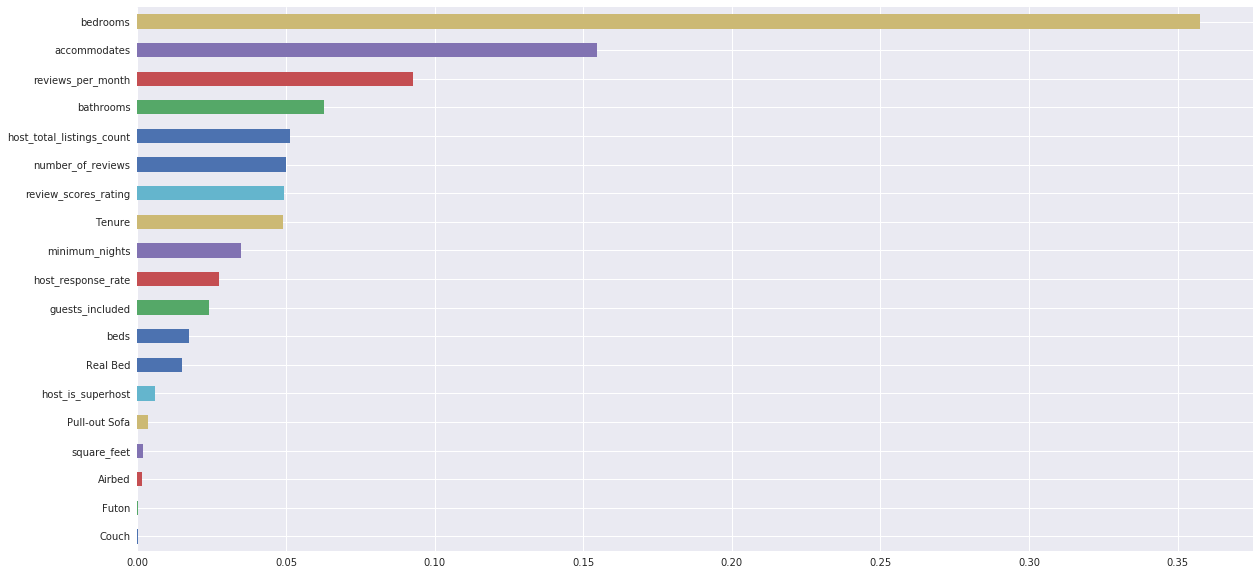

In [298]:
feat_importances = pd.Series(model.feature_importances_, index=train_X.columns)
plt.figure(figsize=(20,10))
feat_importances.sort_values(ascending=True).plot(kind='barh')

#### The main features that define the price are bedrooms,accomodation ,reviews per month,bathrooms,rating. Note that the number of reviews and reviews per month are direct function of their historical sales data

#### The main features that define the price are bedrooms,accomodation ,reviews per month,bathrooms,rating

In [14]:
listing['host_is_superhost'] = listing['host_is_superhost'].map({'f':0,'t':1})

In [47]:
rv_df = listing[['id','host_is_superhost','number_of_reviews','review_scores_rating']]